In [62]:
!pip install snakeviz
!pip install joblib

In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sklearn
%matplotlib inline

# A very hard function

In [64]:
X = np.random.randn(1000) + 8.342

In [65]:
def scalar_sum(X, y):
    return sum( x*y for x in X )

def pairwise_sum(X):
    return( sum( scalar_sum(X, y) for y in X ) )

In [66]:
pairwise_sum(X)

69944820.23232244

In [67]:
%%timeit 
pairwise_sum(X)

416 ms ± 22.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Profiling

### Level 1 crook: just see if its slow

In [68]:
%%timeit
pairwise_sum(X)

442 ms ± 36.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Level 10: cprofile via %%pprun, get what takes the most time

In [70]:
%%prun -s cumulative -q -l 10 -T prun0

times = 10
for i in range(times):
    pairwise_sum(X)

print(open('prun0', 'r').read())

         23941746 function calls (23797846 primitive calls) in 15.919 seconds

   Ordered by: cumulative time
   List reduced from 210 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   15.919   15.919 {built-in method builtins.exec}
        1    0.031    0.031   15.919   15.919 <string>:1(<module>)
      100    0.225    0.002   15.888    0.159 <ipython-input-65-5b302972ac1f>:1(compute_parwise_products)
    46500    0.110    0.000   11.988    0.000 common.py:49(new_method)
    46500    0.204    0.000   11.721    0.000 __init__.py:495(wrapper)
    46500    0.175    0.000    6.289    0.000 __init__.py:448(_construct_result)
    46500    0.499    0.000    5.717    0.000 series.py:183(__init__)
    46500    0.343    0.000    3.660    0.000 array_ops.py:156(arithmetic_op)
    93100    0.346    0.000    2.956    0.000 blocks.py:2987(get_block_type)
      100    0.001    0.000    2.539    0.025 frame.py:414(__in

### Level 100 boss: snakeviz

In [71]:
%load_ext snakeviz

In [75]:
%%snakeviz

times = 10
for i in range(times):
    pairwise_sum(X)

print(open('prun0', 'r').read())

         10040076 function calls (10030076 primitive calls) in 6.024 seconds

   Ordered by: cumulative time
   List reduced from 30 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    6.024    6.024 {built-in method builtins.exec}
        1    0.000    0.000    6.024    6.024 <string>:1(<module>)
       10    0.000    0.000    6.023    0.602 <ipython-input-65-cd67089fa966>:4(pairwise_sum)
 10010/10    2.969    0.000    6.023    0.602 {built-in method builtins.sum}
    10010    0.010    0.000    6.017    0.001 <ipython-input-65-cd67089fa966>:5(<genexpr>)
    10000    0.011    0.000    6.008    0.001 <ipython-input-65-cd67089fa966>:1(scalar_sum)
 10010000    3.033    0.000    3.033    0.000 <ipython-input-65-cd67089fa966>:2(<genexpr>)
        1    0.000    0.000    0.001    0.001 {built-in method builtins.print}
        2    0.000    0.000    0.001    0.000 iostream.py:386(write)
        3    0.000    0.00

# Multiprocessing

In [34]:
from multiprocessing import Pool

In [35]:
def scalar_wrapper(args):
    return scalar_sum(*args)

p = Pool(4)
%timeit sum(p.map( scalar_wrapper, ((X, y) for y in X) ))
p.close()

126 ms ± 12.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Joblib

In [36]:
from joblib import Parallel, delayed

In [37]:
%timeit sum(Parallel(n_jobs=4)(delayed(scalar_wrapper)((X, y)) for y in X))

143 ms ± 23.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Cython

In [38]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [39]:
%%cython
cimport numpy

cdef double scalar_sum_optim(double* X, double y, int n):
    cdef int i
    cdef double _sum = 0.0
    
    for i in range(n):
        _sum += X[i] * y
    
    return _sum

cpdef pairwise_sum_optim(numpy.ndarray X_ndarray):
    cdef int i, n = X_ndarray.shape[0]
    cdef double* X = <double*> X_ndarray.data
    cdef double _sum = 0.0
    
    for i in range(n):
        _sum += scalar_sum_optim(X, X[i], n)
        
    return _sum

In [40]:
%%timeit
pairwise_sum_optim(X)

1.64 ms ± 6.31 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Cython + Joblib + Turning GIL off

In [41]:
%%cython
cimport numpy
from joblib import Parallel, delayed

cdef double scalar_sum_hyperoptim(double* X, double* y, int n, int m) nogil:
    cdef int i, j
    cdef double _sum = 0.0
    
    for i in range(n):
        for j in range(m):
            _sum += X[i] * y[j]
    
    return _sum

cpdef double scalar_wrapper(numpy.ndarray X_ndarray, numpy.ndarray y_ndarray):
    cdef double* X = <double*> X_ndarray.data
    cdef double* y = <double*> y_ndarray.data
    cdef int n = X_ndarray.shape[0], m = y_ndarray.shape[0]
    cdef double _sum
    
    with nogil:
        _sum = scalar_sum_hyperoptim(X, y, n, m)
    return _sum

cpdef pairwise_sum_hyperoptim(numpy.ndarray X, int n_threads=1):
    cdef double _sum
    
    _sum = sum( Parallel(n_jobs=n_threads, backend='threading')([ delayed(scalar_wrapper, check_pickle=False)(X, X[i::n_threads]) for i in range(n_threads) ]) )
        
    return _sum

In [42]:
X = np.random.randn(10000) + 8.342

In [43]:
%timeit pairwise_sum_optim(X)

167 ms ± 283 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [44]:
%timeit pairwise_sum_hyperoptim(X, n_threads=4)

44.6 ms ± 209 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Numba

In [45]:
import numba
from numba import jit, prange

In [46]:
X = np.random.randn(1000) + 8.342

In [50]:
@jit(nopython=True) # Do not set parallel=True here or it will crash
def scalar_sum_numba(X, y): 
    running_sum = 0
    for i in range(len(X)):
        running_sum += y * X[i]
    return running_sum

@jit(nopython=True, parallel=True)
def pairwise_sum_numba(X):
    running_sum = 0
    for i in prange(len(X)): # Parallelized!
        running_sum += scalar_sum_numba(X, X[i])
    return running_sum

In [51]:
pairwise_sum_numba(X)

69412062.18552035

In [52]:
%timeit pairwise_sum_numba(X)

566 µs ± 54.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Dask

In [14]:
!pip install dask distributed graphviz

In [11]:
from dask.distributed import Client
from dask import delayed

client = Client(n_workers=4)

/home/boris/.local/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39955 instead
  warnings.warn(


In [47]:
def scalar_sum(X, y):
    return sum( x*y for x in X )

def pairwise_sum_chunk(X, ys):
    running_sum = 0
    for y in ys:
        running_sum += scalar_sum(X, y)
    return running_sum

def pairwise_sum_dask_schedule(X, chunks=10):
    chunk_size = X.shape[0]//chunks
    results = []
    for i in range(0, len(X), chunk_size):
        chunk_ys = X[i:i+chunk_size]
        results.append(delayed(pairwise_sum_chunk)(X, chunk_ys))

    total = delayed(sum)(results)
    return total

total = pairwise_sum_dask_schedule(X)
total

Delayed('sum-9a07b26d-ddbf-44d1-b9ad-3fefac027827')

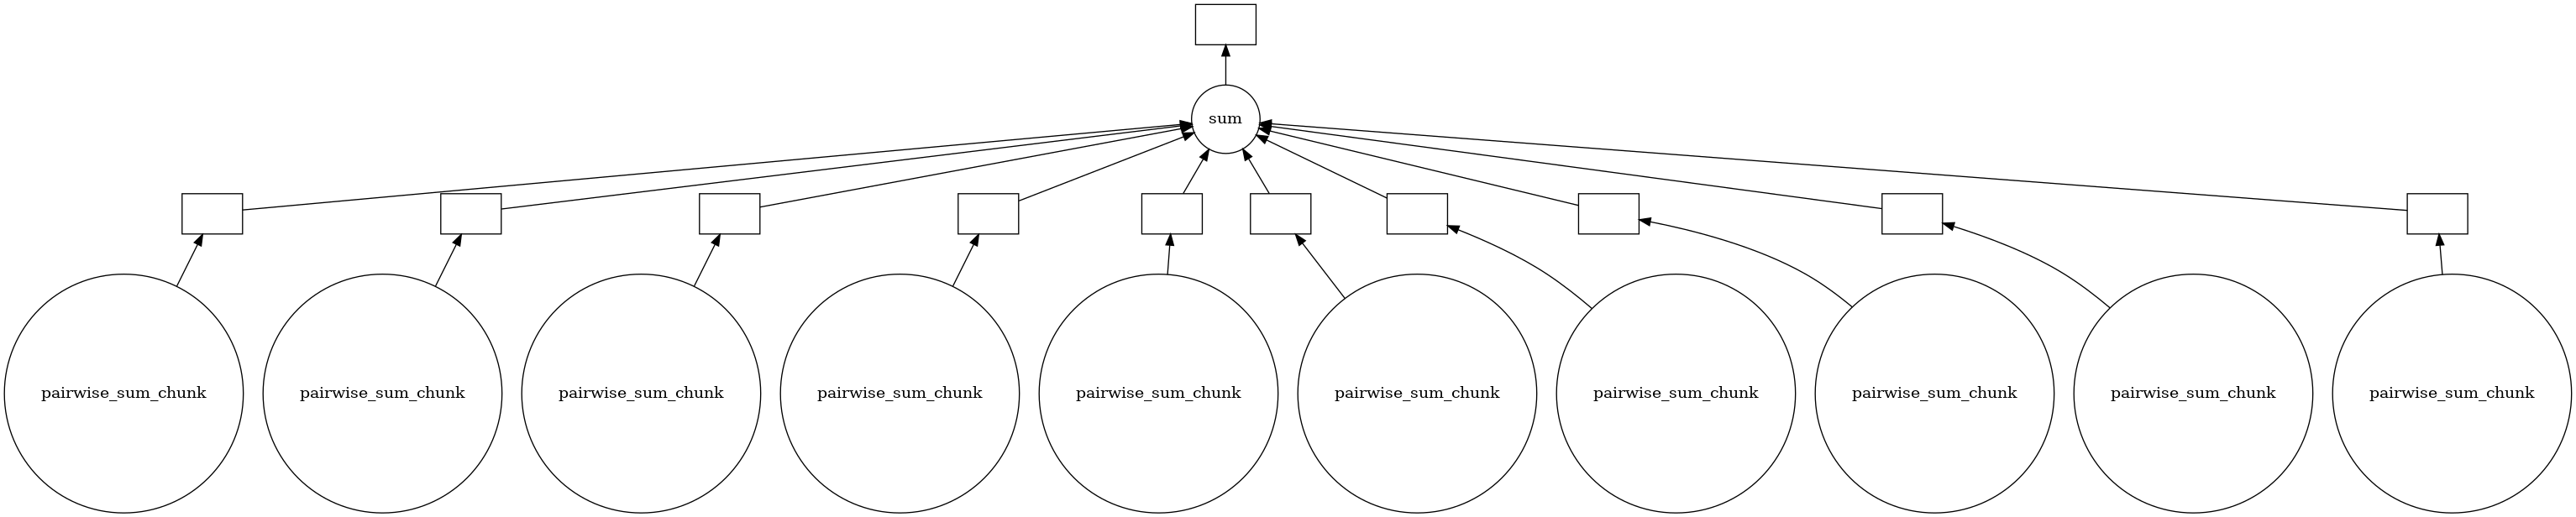

In [48]:
# Cool visualization will only appear if you have graphviz system lib installed
# Try: apt-get install graphviz
total.visualize()

In [49]:
total.compute()

69354347.35005006

In [50]:
%%timeit

total = pairwise_sum_dask_schedule(X)

698 µs ± 15.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [53]:
%%timeit

total = pairwise_sum_dask_schedule(X)
total.compute()

169 ms ± 5.94 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [3]:
client.close()